# Import Library

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.stats import zscore
import kagglehub

# Import Dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("ricgomes/global-fashion-retail-stores-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/global-fashion-retail-stores-dataset


In [ ]:
#mengubah ke path object
dataset_path = Path(path)
#menampilkan semua file dalam folder dataset
for file in dataset_path.iterdir():
    print(file.name)

discounts.csv
products.csv
employees.csv
stores.csv
customers.csv
transactions.csv


# Data Wrangling

In [ ]:
# Load dengan dtype dan kolom yang penting
transactions = pd.read_csv(dataset_path/"transactions.csv", encoding='latin1',
                           usecols=['Invoice ID', 'Date', 'Product ID', 'Discount', 'Quantity', 'Unit Price', 'Customer ID', 'Transaction Type', 'Payment Method', 'Invoice Total'],
                           dtype={
                               'Invoice ID': 'str',
                               'Product ID': 'str',
                               'Discount': 'float32',
                               'Quantity': 'int16',
                               'Unit Price': 'float32',
                               'Customer ID': 'str',
                               'Transaction Type': 'category',
                               'Payment Method': 'category',
                               'Invoice Total': 'float32'

                           })

customers = pd.read_csv(dataset_path/"customers.csv", encoding='latin1',
                        usecols=['Customer ID', 'Gender', 'City', 'Country', 'Date Of Birth', 'Job Title'],
                        dtype={
                            'Customer ID': 'str',
                            'Gender': 'category',
                            'City': 'category',
                            'Country': 'category',
                            'Job Title': 'category'
                        })

products = pd.read_csv(dataset_path/"products.csv", encoding='latin1',
                       usecols=['Product ID', 'Category', 'Sub Category', 'Production Cost'],
                       dtype={
                           'Product ID': 'str',
                           'Category': 'category',
                           'Sub Category': 'category',
                           'Production Cost': 'float32'
                       })

discounts = pd.read_csv(dataset_path/"discounts.csv", encoding='latin1',
                        usecols=['Category', 'Start', 'End', 'Discont'],
                        dtype={
                            'Category': 'category',
                            'Discont': 'float32'
                        })

In [ ]:
# Convert tanggal
transactions['Date'] = pd.to_datetime(transactions['Date'])
customers['Date Of Birth'] = pd.to_datetime(customers['Date Of Birth'])
discounts['Start'] = pd.to_datetime(discounts['Start'])
discounts['End'] = pd.to_datetime(discounts['End'])

In [ ]:
# Merge customers (ambil hanya kolom perlu)
transactions = transactions.merge(customers, on='Customer ID', how='left')

# Hitung umur
transactions['Age'] = transactions['Date'].dt.year - transactions['Date Of Birth'].dt.year

# Merge products
transactions = transactions.merge(products, on='Product ID', how='left')

# Hitung profit
transactions['Profit'] = (transactions['Unit Price'] - transactions['Production Cost']) * transactions['Quantity']

# Flag diskon
transactions['is_discounted'] = transactions['Discount'].fillna(0) > 0

In [ ]:
# Buat diskon aktif per kategori dan tanggal
discounts_expanded = []
for _, row in discounts.iterrows():
    dates = pd.date_range(row['Start'], row['End'])
    for d in dates:
        discounts_expanded.append({'Category': row['Category'], 'Date': d, 'Discount': row['Discont']})

discounts_expanded_df = pd.DataFrame(discounts_expanded)

In [ ]:
# Merge diskon
transactions = transactions.merge(discounts_expanded_df, on=['Category', 'Date'], how='left')
transactions['Category_Discount'] = transactions['Discount_y'].fillna(0)
transactions.drop(columns=['Discount_y'], inplace=True)
transactions.rename(columns={'Discount_x':'Discount'}, inplace=True)

In [ ]:
# Pilih kolom yang dibutuhkan
df = transactions[[
    'Invoice ID', 'Date', 'Product ID', 'Category', 'Sub Category',
    'Unit Price', 'Production Cost', 'Quantity', 'Profit', 'Discount', 'Category_Discount',
    'Customer ID', 'Gender', 'Age', 'City', 'Country', 'Job Title',
    'Transaction Type', 'Payment Method', 'Invoice Total'
]]

# Cek tipe data untuk memastikan hemat memori
print(df.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6518594 entries, 0 to 6518593
Data columns (total 20 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Invoice ID         object        
 1   Date               datetime64[ns]
 2   Product ID         object        
 3   Category           object        
 4   Sub Category       category      
 5   Unit Price         float32       
 6   Production Cost    float32       
 7   Quantity           int16         
 8   Profit             float32       
 9   Discount           float32       
 10  Category_Discount  float64       
 11  Customer ID        object        
 12  Gender             category      
 13  Age                int32         
 14  City               category      
 15  Country            category      
 16  Job Title          category      
 17  Transaction Type   category      
 18  Payment Method     category      
 19  Invoice Total      float32       
dtypes: category(7), datetime

# Exploratory Data Analysis (EDA)

In [ ]:
print('Statistika Deskriptif Dataset:\n',df.describe())

Statistika Deskriptif Dataset:
                                 Date    Unit Price  Production Cost  \
count                        6518594  6.518594e+06     6.518594e+06   
mean   2024-03-12 00:02:11.080496896  1.324109e+02     1.732504e+01   
min              2023-01-01 00:00:00  2.000000e+00     5.600000e-01   
25%              2023-09-20 10:13:00  3.250000e+01     8.650000e+00   
50%              2024-03-11 09:30:00  5.100000e+01     1.432000e+01   
75%              2024-10-06 19:22:00  1.165000e+02     2.263000e+01   
max              2025-03-18 20:59:00  1.153500e+03     7.719000e+01   
std                              NaN  1.861192e+02     1.199817e+01   

           Quantity        Profit      Discount  Category_Discount  \
count  6.518594e+06  6.518594e+06  6.518594e+06       6.518594e+06   
mean   1.100281e+00  1.266415e+02  1.171991e-01       9.982820e-03   
min    1.000000e+00 -4.344001e+01  0.000000e+00       0.000000e+00   
25%    1.000000e+00  1.949000e+01  0.000000e+00 

In [ ]:
print('Cek Missing Value:\n',df.isnull().sum())

Cek Missing Value:
 Invoice ID                 0
Date                       0
Product ID                 0
Category                   0
Sub Category               0
Unit Price                 0
Production Cost            0
Quantity                   0
Profit                     0
Discount                   0
Category_Discount          0
Customer ID                0
Gender                     0
Age                        0
City                       0
Country                    0
Job Title            2284256
Transaction Type           0
Payment Method             0
Invoice Total              0
dtype: int64


In [ ]:
print('Cek Duplikasi Data:\n',df.duplicated().sum())

Cek Duplikasi Data:
 104266


In [ ]:
print("\nStatistik deskriptif (kategorikal):")
print(df.describe(include='object'))


Statistik deskriptif (kategorikal):
                 Invoice ID Product ID  Category Customer ID
count               6518594    6518594   6518594     6518594
unique              4540404      17940         3     1283707
top     RET-UK-016-03478388      14729  Feminine       78842
freq                     52       1009   3142363          69


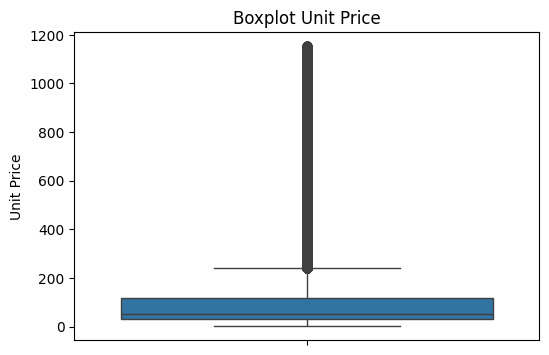

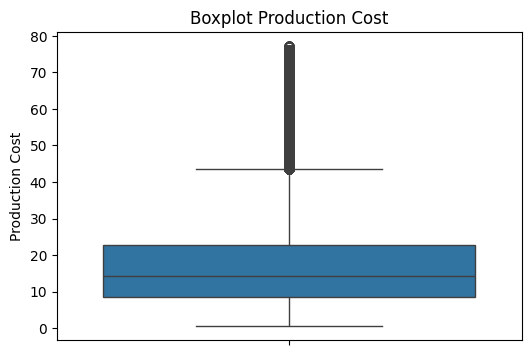

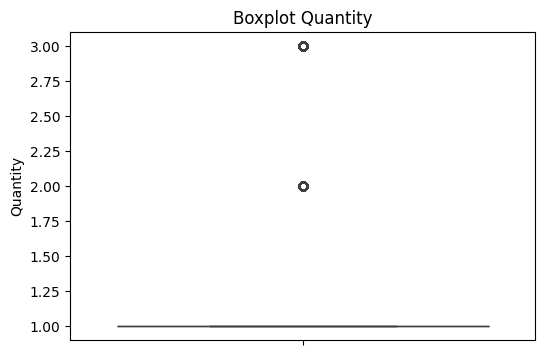

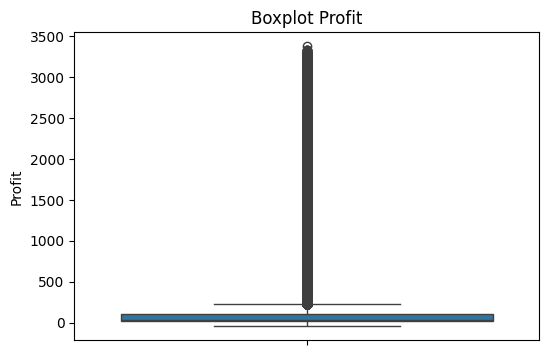

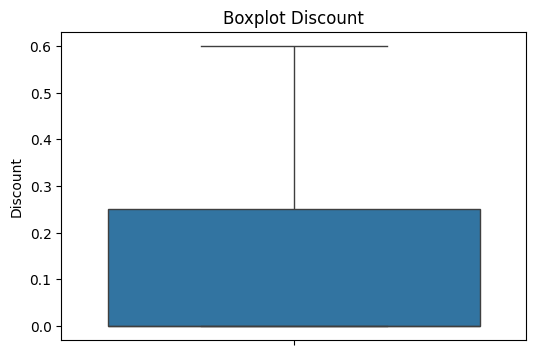

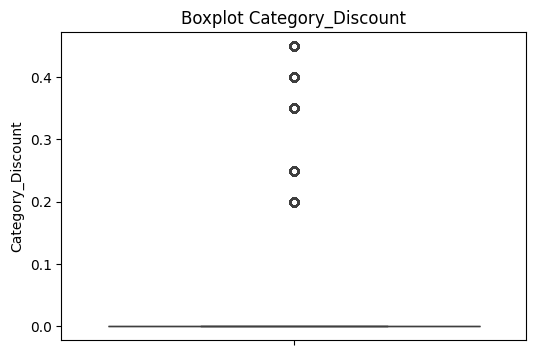

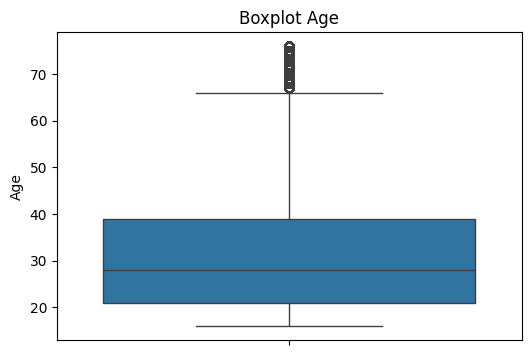

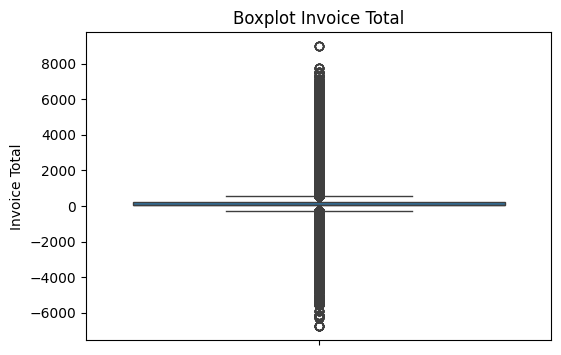

In [ ]:
numeric = df.select_dtypes(include=['float64', 'int32', 'int16', 'float32'])
for col in numeric:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=df[col])
    plt.xticks(rotation=45)
    plt.title(f'Boxplot {col}')
    plt.show()

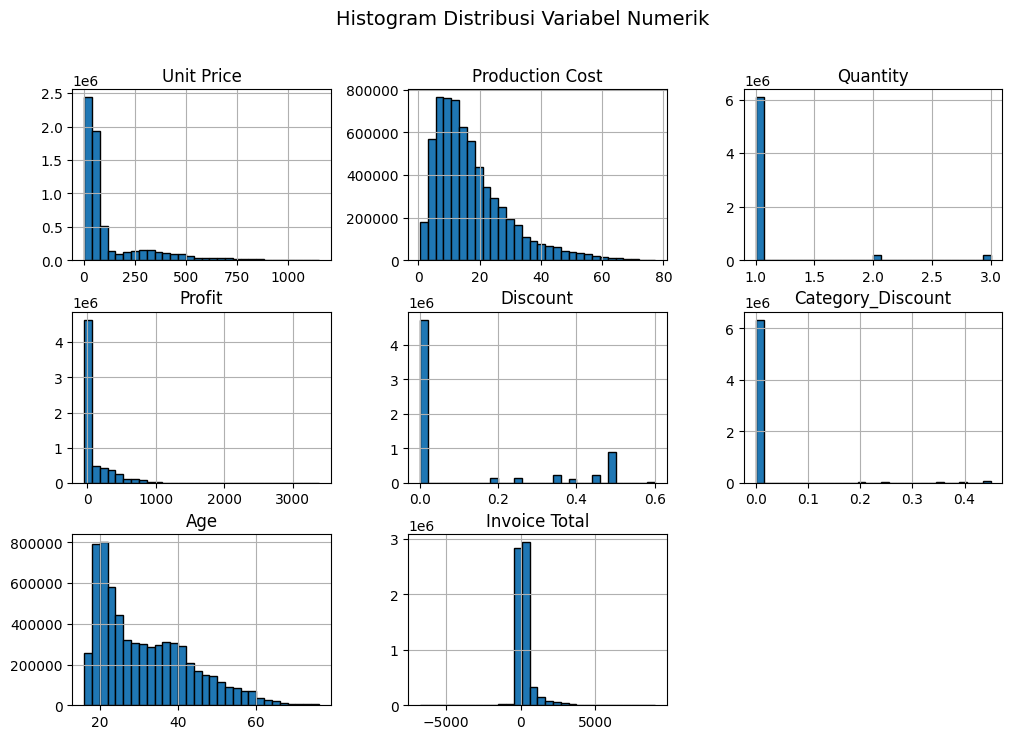

In [ ]:
numeric.hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Histogram Distribusi Variabel Numerik", fontsize=14)
plt.show()

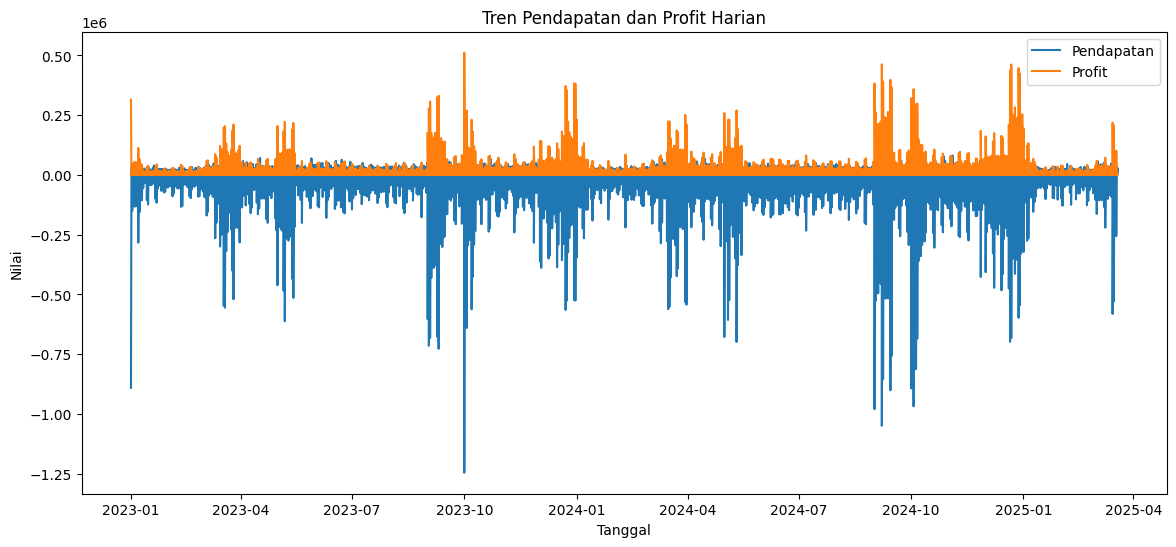

In [ ]:
#Tren Pendapatan dan Profit Harian
daily_finance = df.groupby('Date').agg({
    'Invoice Total': 'sum',
    'Profit': 'sum'
}).reset_index()

plt.figure(figsize=(14,6))
sns.lineplot(x='Date', y='Invoice Total', data=daily_finance, label='Pendapatan')
sns.lineplot(x='Date', y='Profit', data=daily_finance, label='Profit')
plt.title('Tren Pendapatan dan Profit Harian')
plt.xlabel('Tanggal')
plt.ylabel('Nilai')
plt.legend()
plt.show()


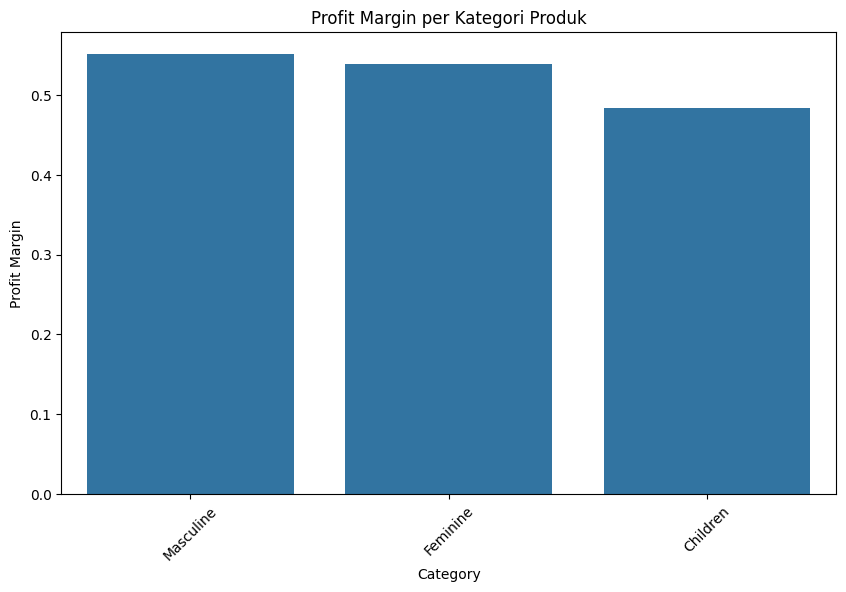

In [ ]:
#Profit Margin per Kategori Produk
category_margin = df.groupby('Category').agg({
    'Invoice Total': 'sum',
    'Profit': 'sum'
}).assign(Profit_Margin=lambda x: x['Profit'] / x['Invoice Total'])

category_margin = category_margin.sort_values('Profit_Margin', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=category_margin.index, y='Profit_Margin', data=category_margin)
plt.title('Profit Margin per Kategori Produk')
plt.ylabel('Profit Margin')
plt.xticks(rotation=45)
plt.show()


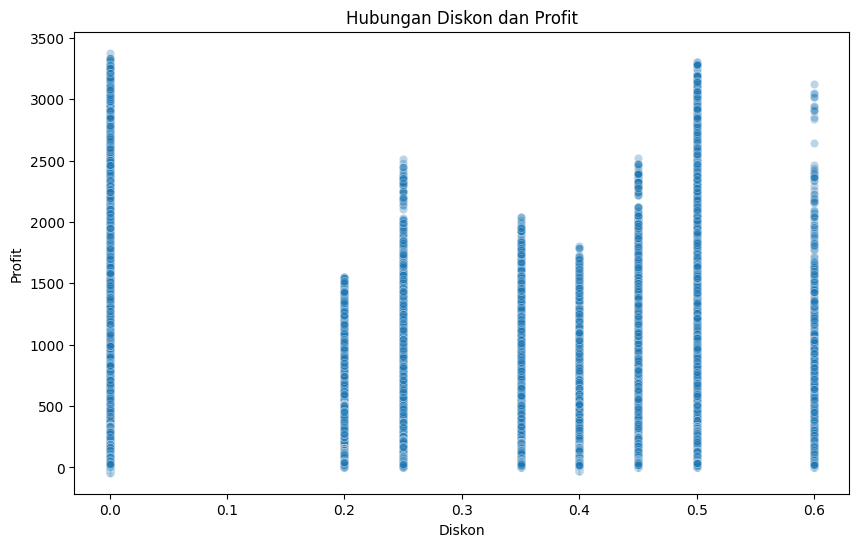

In [ ]:
# Diskon vs Profitabilitas
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Discount', y='Profit', alpha=0.3)
plt.title('Hubungan Diskon dan Profit')
plt.xlabel('Diskon')
plt.ylabel('Profit')
plt.show()


<ipython-input-19-2699751106>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-19-2699751106>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


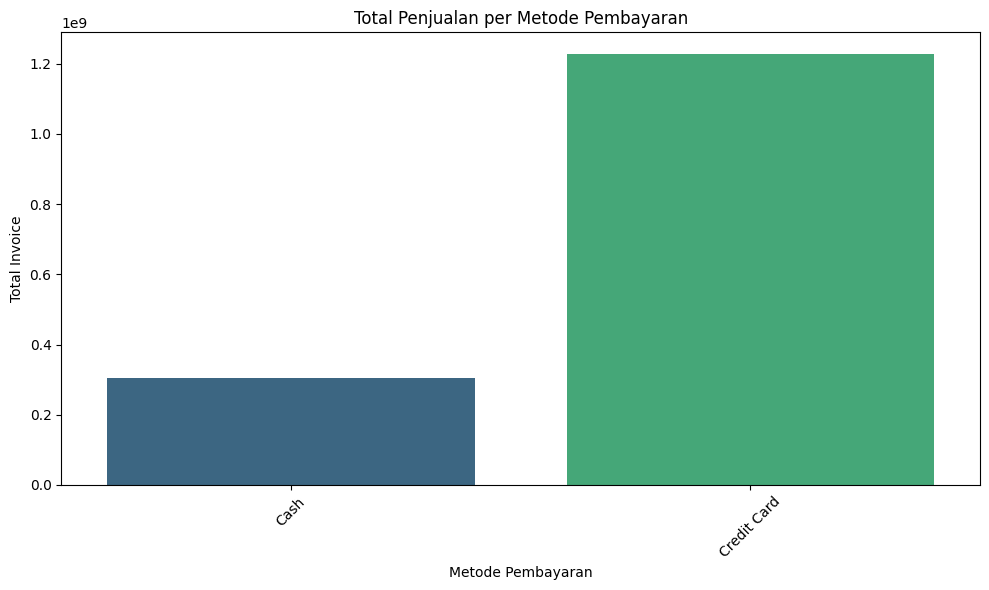

In [ ]:
#Barplot Total Penjualan per Metode Pembayaran
plt.figure(figsize=(10,6))
sns.barplot(
    data=df,
    x='Payment Method',
    y='Invoice Total',
    estimator='sum',
    ci=None,
    palette='viridis'
)
plt.title('Total Penjualan per Metode Pembayaran')
plt.ylabel('Total Invoice')
plt.xlabel('Metode Pembayaran')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-20-613641081>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Sub Category')['Quantity']
<ipython-input-20-613641081>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products, x='Quantity', y='Sub Category', palette='viridis')


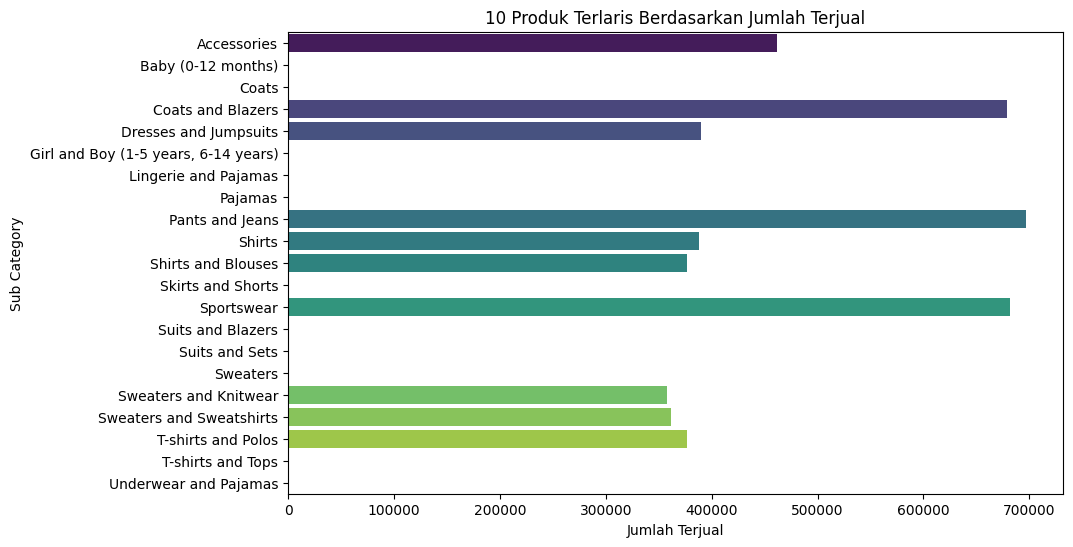

In [ ]:
#Produk Terlaris
top_products = (
    df.groupby('Sub Category')['Quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

plt.figure(figsize=(10,6))
sns.barplot(data=top_products, x='Quantity', y='Sub Category', palette='viridis')
plt.title('10 Produk Terlaris Berdasarkan Jumlah Terjual')
plt.xlabel('Jumlah Terjual')
plt.ylabel('Sub Category')
plt.show()


<ipython-input-21-4022341373>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['Sub Category', 'Gender'])['Quantity']
<ipython-input-21-4022341373>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Sub Category')['Quantity']


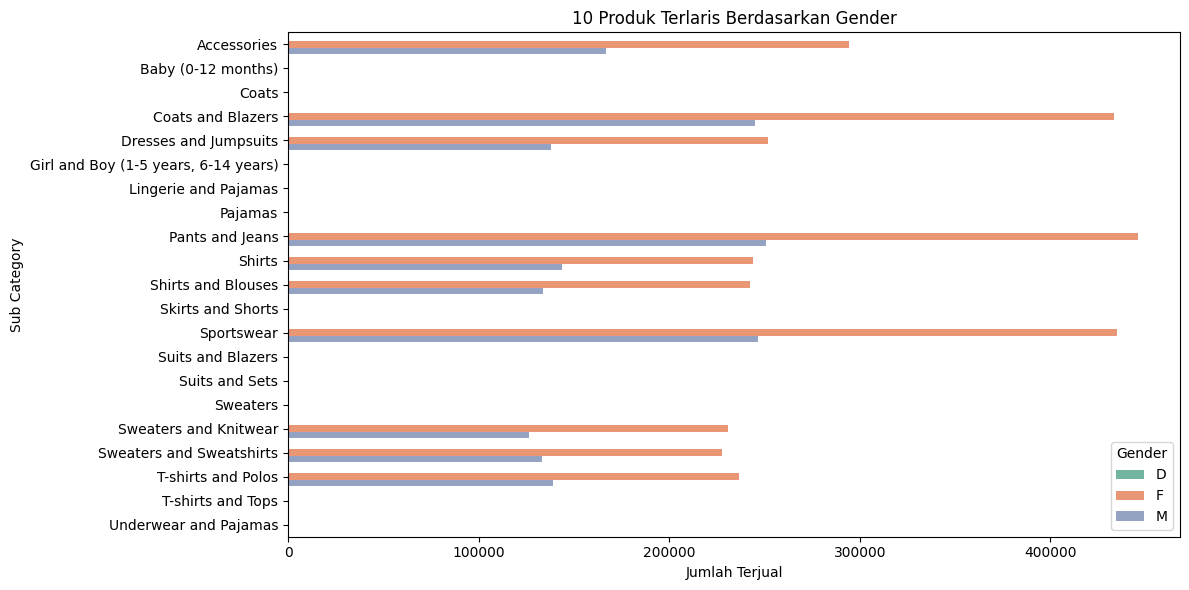

In [ ]:
# Hitung total quantity per produk per gender
top_by_gender = (
    df.groupby(['Sub Category', 'Gender'])['Quantity']
    .sum()
    .reset_index()
)

# Ambil 10 produk dengan total penjualan terbanyak
top_products=(
    df.groupby('Sub Category')['Quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Filter hanya produk-produk top
top_by_gender = top_by_gender[top_by_gender['Sub Category'].isin(top_products)]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_by_gender, x='Quantity', y='Sub Category', hue='Gender', palette='Set2')
plt.title('10 Produk Terlaris Berdasarkan Gender')
plt.xlabel('Jumlah Terjual')
plt.ylabel('Sub Category')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


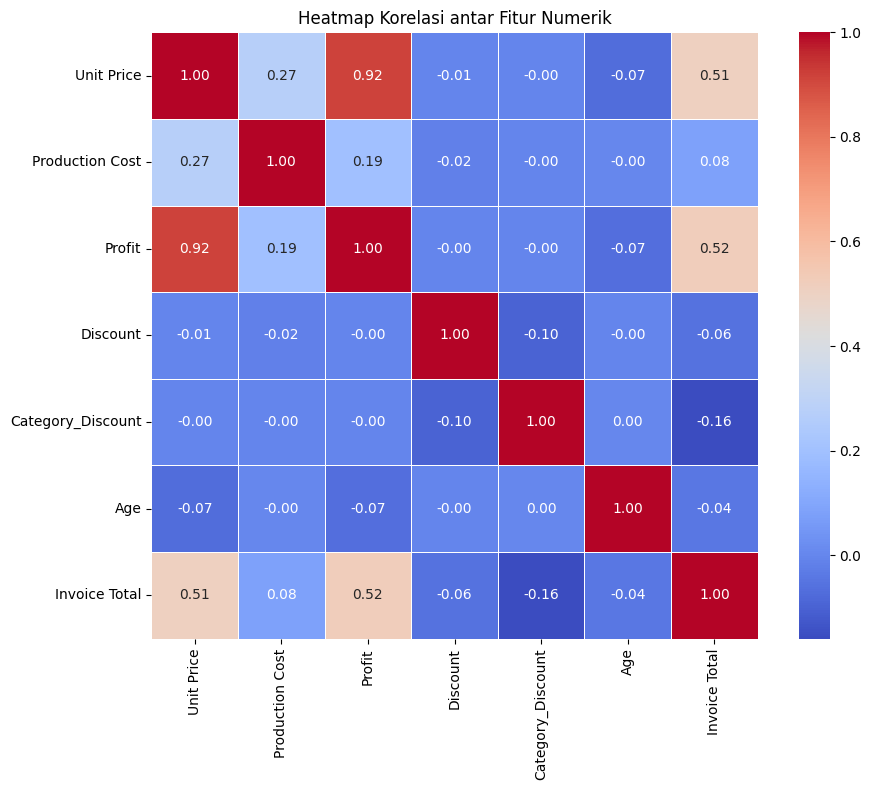

In [ ]:
#Korelasi fitur numerik
num_cols = df.select_dtypes(include=['int', 'float']).columns

# Hitung korelasi
corr_matrix = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Heatmap Korelasi antar Fitur Numerik")
plt.tight_layout()
plt.show()


# Data Preprocessing

In [ ]:
#Drop duplikat
df = df.drop_duplicates()

In [ ]:
#Drop fitur yang tidak dibutuhkan
df = df.dropna(subset=['Job Title','City','Country','Age','Transaction Type'])

## Feature Engineering

In [ ]:
# Hitung Pendapatan per produk
income_per_product = df.groupby('Product ID')['Invoice Total'].sum().reset_index()
income_per_product.rename(columns={'Invoice Total': 'Total_Income'}, inplace=True)

In [ ]:
# Hitung Profit per produk
profit_per_product = df.groupby('Product ID')['Profit'].sum().reset_index()

In [ ]:
# Hitung Pengeluaran per produk
df['Expenses'] = df['Production Cost'] * df['Quantity']
expenses_per_product = df.groupby('Product ID')['Expenses'].sum().reset_index()

In [ ]:
#Perhitungan kuantitas dan diskon produk
quantity_per_product = df.groupby('Product ID')['Quantity'].sum().reset_index()
unitprice_per_product = df.groupby('Product ID')['Unit Price'].mean().reset_index()
discount_per_product = df.groupby('Product ID')['Discount'].mean().reset_index()

In [ ]:
financials_per_product = income_per_product.merge(expenses_per_product, on='Product ID') \
                                           .merge(profit_per_product, on='Product ID')

In [ ]:
# Gabungkan semua ke financials_per_product
financials_per_product = financials_per_product.merge(quantity_per_product, on='Product ID')
financials_per_product = financials_per_product.merge(unitprice_per_product, on='Product ID')
financials_per_product = financials_per_product.merge(discount_per_product, on='Product ID')

In [ ]:
#Hitung Profit Margin
financials_per_product['Profit_Margin'] = financials_per_product['Profit'] / financials_per_product['Total_Income']

# Pembangunan Model Clustering

In [ ]:
features = ['Total_Income', 'Profit_Margin']
X_raw = financials_per_product[features].copy()

In [ ]:
X_offset = X_raw - X_raw.min() + 1
X_log = np.log1p(X_offset)

Q1 = X_log.quantile(0.25)
Q3 = X_log.quantile(0.75)
IQR = Q3 - Q1
mask = ~((X_log < (Q1 - 1.5 * IQR)) | (X_log > (Q3 + 1.5 * IQR))).any(axis=1)
X_filtered = X_log[mask]
financials_filtered = financials_per_product.loc[X_filtered.index].reset_index(drop=True)


In [ ]:
# Standardisasi
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_filtered)

In [ ]:
#Korelasi
correlation_matrix = X_filtered.corr()
print(correlation_matrix)

               Total_Income  Profit_Margin
Total_Income       1.000000       0.361959
Profit_Margin      0.361959       1.000000


In [ ]:
7#PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
#Clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_pca)
financials_filtered['Cluster'] = labels

In [ ]:
#Evaluasi
score = silhouette_score(X_pca, labels)
print(f"Silhouette Score (PCA + Feature Selection): {score:.3f}")

Silhouette Score (PCA + Feature Selection): 0.428


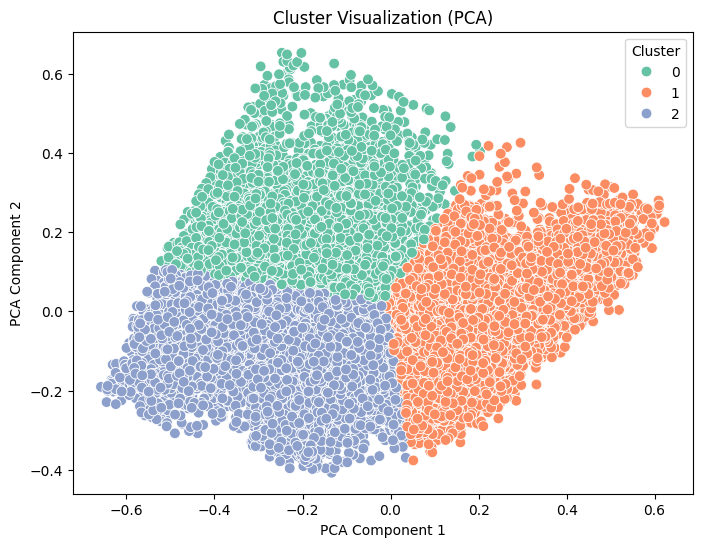

In [ ]:
#Visualisasi
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='Set2', s=60)
plt.title('Cluster Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [ ]:
cluster_summary = financials_filtered.groupby('Cluster')[['Profit_Margin', 'Total_Income','Profit']].mean()
print(cluster_summary)

         Profit_Margin  Total_Income        Profit
Cluster                                           
0             0.536433   9832.134766   5346.862793
1             0.501876  77678.281250  40815.410156
2             0.276733  16513.662109   4705.177246


In [ ]:
def assign_label(cluster_id):
    if cluster_id == cluster_summary['Profit_Margin'].idxmax():
        return 'Sehat'
    elif cluster_id == cluster_summary['Profit_Margin'].idxmin():
        return 'Tidak Sehat'
    else:
        return 'Waspada'

financials_filtered['Health_Status'] = financials_filtered['Cluster'].apply(assign_label)

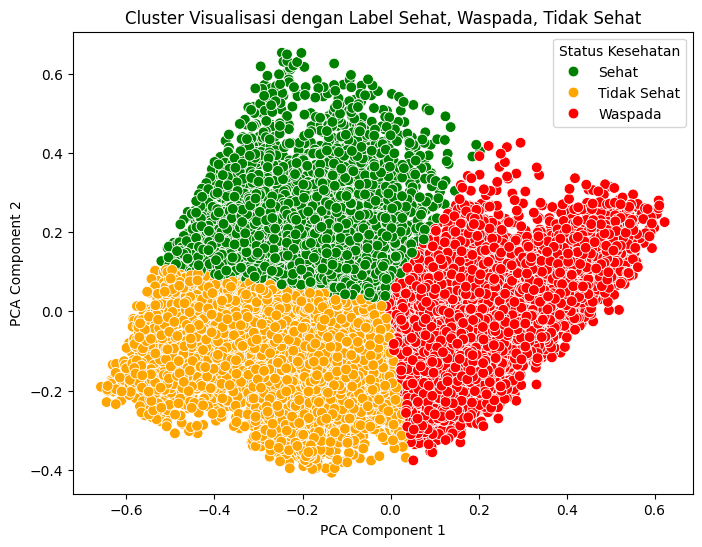

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=financials_filtered['Health_Status'],
                palette=['green', 'orange', 'red'], s=60)
plt.title('Cluster Visualisasi dengan Label Sehat, Waspada, Tidak Sehat')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Status Kesehatan')
plt.show()


In [ ]:
df_clean = df.drop_duplicates().dropna()

# 2. Dari financials_filtered buat dataframe cluster + label
cluster_summary = financials_filtered.groupby('Cluster')[['Profit', 'Total_Income']].mean()

def assign_label(cluster_id):
    if cluster_id == cluster_summary['Profit'].idxmax():
        return 'Sehat'
    elif cluster_id == cluster_summary['Profit'].idxmin():
        return 'Tidak Sehat'
    else:
        return 'Waspada'

clusters_df = financials_filtered[['Product ID', 'Cluster']].copy()
clusters_df['Health_Status'] = clusters_df['Cluster'].apply(assign_label)

# 3. Merge ke df_clean berdasarkan Product ID
df_merged = df_clean.merge(clusters_df[['Product ID', 'Cluster', 'Health_Status']],
                           on='Product ID', how='left')

# 4. Produk yang gak ada di cluster bisa diisi label 'Unknown'
df_merged['Cluster'] = df_merged['Cluster'].fillna(-1).astype(int)  # Cluster -1 artinya no cluster
df_merged['Health_Status'] = df_merged['Health_Status'].fillna('Unknown')

# 5. Cek hasilnya
print(df_merged.info())
print(df_merged)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4166002 entries, 0 to 4166001
Data columns (total 23 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Invoice ID         object        
 1   Date               datetime64[ns]
 2   Product ID         object        
 3   Category           object        
 4   Sub Category       category      
 5   Unit Price         float32       
 6   Production Cost    float32       
 7   Quantity           int16         
 8   Profit             float32       
 9   Discount           float32       
 10  Category_Discount  float64       
 11  Customer ID        object        
 12  Gender             category      
 13  Age                int32         
 14  City               category      
 15  Country            category      
 16  Job Title          category      
 17  Transaction Type   category      
 18  Payment Method     category      
 19  Invoice Total      float32       
 20  Expenses           float

In [ ]:
jumlah_target = df_merged['Health_Status'].value_counts()
print("Jumlah Produk per Status Kesehatan (Target):")
print(jumlah_target)

Jumlah Produk per Status Kesehatan (Target):
Health_Status
Sehat          3315433
Tidak Sehat     617203
Waspada         219331
Unknown          14035
Name: count, dtype: int64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_csv_path = "/content/drive/My Drive/products_with_financial_clusters.csv"
df_merged.to_csv(output_csv_path, index=False)

In [ ]:
json_data = df_merged.to_json(orient='records', indent=4)
output_json_path = "/content/drive/My Drive/products_with_financial_clusters.json"
with open(output_json_path, 'w') as f:
    f.write(json_data)